In [1]:
%matplotlib inline


# Source localization with single dipole fit


The aim of this lecture is to show you how to do sequential and
fixed dipole fitting with MNE-Python.

In [2]:
from os import path as op
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.forward import make_forward_dipole
from mne.evoked import combine_evoked
from mne.simulation import simulate_evoked

data_path = mne.datasets.sample.data_path()
subjects_dir = op.join(data_path, 'subjects')
fname_ave = op.join(data_path, 'MEG', 'sample', 'sample_audvis-ave.fif')
fname_cov = op.join(data_path, 'MEG', 'sample', 'sample_audvis-cov.fif')
fname_bem = op.join(subjects_dir, 'sample', 'bem', 'sample-5120-bem-sol.fif')
fname_trans = op.join(data_path, 'MEG', 'sample',
                      'sample_audvis_raw-trans.fif')
fname_surf_lh = op.join(subjects_dir, 'sample', 'surf', 'lh.white')

Let's localize the N100m (using MEG only)



In [3]:
evoked = mne.read_evokeds(fname_ave, condition='Right Auditory', baseline=(None, 0))
evoked.pick_types(meg=True, eeg=False)

<Evoked  |  comment : 'Right Auditory', kind : average, time : [-0.199795, 0.499488], n_epochs : 61, n_channels x n_times : 305 x 421>

In [4]:
# Fit a dipole using a sequential (time-varying position and orientation) fit
evoked_crop = evoked.copy().crop(0.075, 0.09)
dip, residual = mne.fit_dipole(evoked_crop, fname_cov, fname_bem, fname_trans)
print(dip)

<Dipole  |  n_times : 10, tmin : 0.0749232049344, tmax : 0.0899078459213>


In [5]:
# Look at our result
print(dip.gof)

[ 54.21184303  55.55860396  56.45880715  56.94524719  57.04731571
  56.79357702  56.22167919  55.38054513  54.32225115  53.10967138]


Calculate and visualise magnetic field predicted by dipole with maximum GOF
and compare to the measured data, highlighting the ipsilateral (right) source



In [6]:
# find time point with highest GOF
best_idx = np.argmax(dip.gof)
best_time = dip.times[best_idx]
best_gof = dip.gof[best_idx]
best_pos = dip.pos[best_idx]
print('t=%0.3f, gof=%0.1f%%, pos=%s' % (best_time, best_gof, best_pos))

t=0.082, gof=57.0%, pos=[-0.06146826  0.00491014  0.05961037]


Estimate the time course of our best-GOF dipole by using a fixed position
and orientation (the one that maximized GOF) over the entire interval

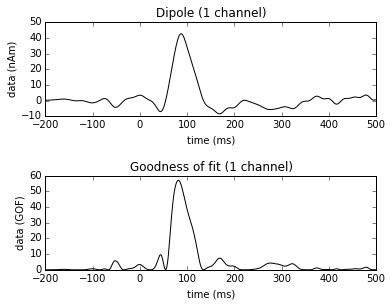

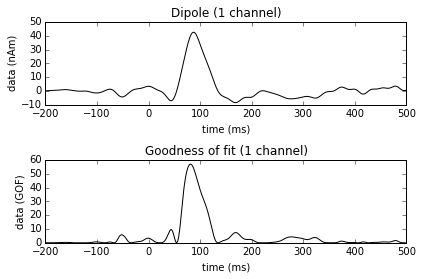

In [7]:
best_ori = dip.ori[best_idx]
dip_fixed = mne.fit_dipole(evoked, fname_cov, fname_bem, fname_trans,
                           pos=best_pos, ori=best_ori)[0]
dip_fixed.plot()

## Exercises
- Try to improve the dipole fit by using a subselection of channels:
    - Subselect channels from ``evoked`` and ``evoked_crop``
      (think about ``mne.read_selection(...)``, ``evoked.pick_channels(...)``)
    - Do a time-varying dipole fit of ``evoked_crop``
    - Do a fixed-position, fixed-orientation fit using ``evoked`` and visualize the result
- What is the improvement in max GOF from using a subselection of channels?
- How far (in mm) is the new best dipole from the original best dipole?